<a href="https://colab.research.google.com/github/CanKeles5/ImproveImgQuality/blob/main/ImageSuperResolutionSRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.utils.data.sampler
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image, ImageFilter
import os
import cv2
import numpy
import random
import fnmatch
import numpy as np
import sys

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [ ]:
! kaggle datasets download -d jessicali9530/celeba-dataset

 98% 1.31G/1.33G [00:12<00:00, 97.0MB/s]
100% 1.33G/1.33G [00:12<00:00, 114MB/s] 


In [ ]:
path = "/content/celeba-dataset.zip"
to = "/content/dataset"
! unzip -q -n {path} -d {to}

In [ ]:
im_path = "/content/dataset/img_align_celeba.zip"
imgs = "/content/images"
! unzip -q -n {im_path} -d {imgs}

unzip:  cannot find or open /content/dataset/img_align_celeba.zip, /content/dataset/img_align_celeba.zip.zip or /content/dataset/img_align_celeba.zip.ZIP.


In [ ]:
folder = "/content/dataset/img_align_celeba/img_align_celeba"

In [ ]:
image_paths = []

for (path, dirnames, filenames) in os.walk(folder):
  image_paths.extend(os.path.join(path, name) for name in filenames)

In [ ]:
class MyDataset(Dataset):
  def __init__(self, image_paths, train=True):
    self.image_paths = image_paths
    
  def transform(self, image):
    resize = transforms.Resize(size=(128, 128))
    image = resize(image)
    image = TF.to_tensor(image)
    
    return image

  def __getitem__(self, index):
    image = Image.open(self.image_paths[index])
    x = self.transform(image)

    return x
  
  def __len__(self):
    return len(self.image_paths)

In [ ]:
'''
class MyDataset(Dataset):
  def __init__(self, image_paths, train=True):
    self.image_paths = image_paths
    
  def transform(self, image):
    resize = transforms.Resize(size=(128, 128))
    image = resize(image)
    image = TF.to_tensor(image)
    
    #image = resize_up(image)
    #image = resize_down(image)
    #image = resize_up(image)

    return image

  def __getitem__(self, index):
    #image = Image.open(self.image_paths[index]) #open the image as PIL image
    orig_image = cv2.imread(self.image_paths[index], cv2.IMREAD_COLOR)
    orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)

    orig_image = orig_image[0:217, 0:177]

    #height, width = orig_image.shape[:2]
    #print(height, width)

    augmented_image = cv2.GaussianBlur(orig_image, (21, 21), 0)
    x = self.transform(orig_image)
    y = self.transform(augmented_image)

    #print("x.shape: ", x.shape)
    #print("y.shape: ", y.shape)

    return x, y
  
  def __len__(self):
    return len(self.image_paths)
'''

'\nclass MyDataset(Dataset):\n  def __init__(self, image_paths, train=True):\n    self.image_paths = image_paths\n    \n  def transform(self, image):\n    resize = transforms.Resize(size=(128, 128))\n    image = resize(image)\n    image = TF.to_tensor(image)\n    \n    #image = resize_up(image)\n    #image = resize_down(image)\n    #image = resize_up(image)\n\n    return image\n\n  def __getitem__(self, index):\n    #image = Image.open(self.image_paths[index]) #open the image as PIL image\n    orig_image = cv2.imread(self.image_paths[index], cv2.IMREAD_COLOR)\n    orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)\n\n    orig_image = orig_image[0:217, 0:177]\n\n    #height, width = orig_image.shape[:2]\n    #print(height, width)\n\n    augmented_image = cv2.GaussianBlur(orig_image, (21, 21), 0)\n    x = self.transform(orig_image)\n    y = self.transform(augmented_image)\n\n    #print("x.shape: ", x.shape)\n    #print("y.shape: ", y.shape)\n\n    return x, y\n  \n  def __len__(sel

In [ ]:
print(len(image_paths))

202599


In [ ]:
train_paths = image_paths[0:10000]
valid_paths = image_paths[10001:12001]

In [ ]:
train_set = MyDataset(train_paths)

In [ ]:
valid_set = MyDataset(valid_paths)

In [ ]:
bs=4

In [ ]:
train_loader = DataLoader(train_set, batch_size=bs)
valid_loader = DataLoader(valid_set, batch_size=bs)

In [ ]:
class DeblurCNN(nn.Module):
    def __init__(self):
        super(DeblurCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)

        return x

In [ ]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=2, padding_mode='replicate')
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2, padding_mode='replicate')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)

        return x

In [ ]:
#Generator = G().to(device)
Generator = SRCNN().to(device)
#Discriminator = D().to(device)

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0, 0.02)
        m.bias.data.normal_(0, 0.001)

In [ ]:
weights_init(Generator)
#weights_init(Discriminator)

In [ ]:
print("Number of parameters in Generator: ", sum([p.numel() for p in Generator.parameters()]))
#print("Number of parameters in Discriminator: ", sum([p.numel() for p in Discriminator.parameters()]))

Number of parameters in Generator:  20099


In [ ]:
criterion = nn.BCELoss()
adv_criterion = nn.BCELoss()
l1_criterion = nn.MSELoss()
G_optim = torch.optim.Adam(Generator.parameters(), lr=1e-3)
#D_optim = torch.optim.Adam(Discriminator.parameters(), lr=1e-5)

In [ ]:
#Discriminator.train()
Generator.train()

SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
)

In [ ]:
def save_pic(epoch_no, im):
  Generator.eval()
  
  im = im.unsqueeze(0).to(device)

  output = Generator(im)
  
  output = output[0].detach().cpu()
  output = (output+1)/2
  output = output.clamp(0.0, 1.0)

  PIL_img = transforms.ToPILImage()(output)
  PIL_img = PIL_img.save(str(epoch_no) + ".jpg")
  Generator.train()

In [ ]:
D_losses_train = []
G_losses_train = []

D_losses_valid = []
G_losses_valid = []

In [ ]:
def shuffle_data(fake_im, real_im):
  batch_size=fake_im.shape[0]

  data=torch.cat((fake_im, real_im),dim=0)
  labels=torch.cat((torch.zeros(batch_size), torch.ones(batch_size)))
  
  return data, labels

In [ ]:
n_epochs = 50

adv_coeff = 0.00

for epoch in range(n_epochs):
  D_train_loss = 0.0
  G_train_loss = 0.0

  D_valid_loss = 0.0
  G_valid_loss = 0.0

  Generator.train()

  for i, real_im in enumerate(train_loader):
    (transforms.ToPILImage()(real_im[0])).save("real_im" + str(epoch) + ".jpg")
    real_im = (real_im*2.0)-1

    augmented_im = real_im.clone()
    augmented_im = transforms.Resize(size=(64, 64))(augmented_im)
    augmented_im = transforms.Resize(size=(128, 128))(augmented_im)

    (transforms.ToPILImage()(augmented_im[0])).save("augmented_im" + str(epoch) + ".jpg")

    augmented_im = augmented_im.to(device)
    real_im = real_im.type(torch.FloatTensor)
    real_im=real_im.to(device)
    
    if i==0:
      save_pic(epoch, augmented_im[0])
    
    ##########MSE loss update############
    G_optim.zero_grad()
    fake_img = Generator(augmented_im)

    G_loss_l1 = l1_criterion(fake_img, real_im)
    G_train_loss += G_loss_l1.item() #for plotting loss
    G_loss_l1.backward(retain_graph=True)
    G_optim.step()
    
    ####################################
    
    ###########################################
  
  Generator.eval()
  
  with torch.no_grad():
    for i, (real_im) in enumerate(valid_loader):
      if(real_im.shape[0]!=bs):
        break

      real_im = 2*real_im-1
      
      augmented_im = real_im.clone()
      augmented_im = transforms.Resize(size=(64, 64))(augmented_im)
      augmented_im = transforms.Resize(size=(128, 128))(augmented_im)

      augmented_im = augmented_im.to(device)
      real_im=real_im.to(device)

      fake_img = Generator(augmented_im)

      if i==0:
        save_pic(epoch, augmented_im[0])

      l1_loss = l1_criterion(fake_img, real_im)
      G_loss = l1_loss
      G_valid_loss += G_loss.item()
  
  G_train_loss = G_train_loss/len(train_set)
  G_valid_loss = G_valid_loss/len(valid_set)
  G_losses_train.append(G_train_loss)
  G_losses_valid.append(G_valid_loss)
  
  print("Epoch " + str(epoch) + ", Train: " + str(G_train_loss) + " , Validation: " + str(G_valid_loss))


Epoch 0, Train: 0.0011531373978359626 , Validation: 0.0006347546695615165
Epoch 1, Train: 0.0006652078674989752 , Validation: 0.0005769579625339248
Epoch 2, Train: 0.0006132089428254403 , Validation: 0.0005185888180858455
Epoch 3, Train: 0.0006107318962749559 , Validation: 0.0004907206977077294
Epoch 4, Train: 0.0006263606774329673 , Validation: 0.0004856831343786325
Epoch 5, Train: 0.0005552607267047279 , Validation: 0.00047517689657979647
Epoch 6, Train: 0.0005411825656774454 , Validation: 0.0004694120936910622
Epoch 7, Train: 0.0005460681404569186 , Validation: 0.00045643653624574654
Epoch 8, Train: 0.0005325925338431262 , Validation: 0.0004813818864058703
Epoch 9, Train: 0.0006245678470644634 , Validation: 0.0004914460101572331
Epoch 10, Train: 0.0004985864857619162 , Validation: 0.00045951001506182364
Epoch 11, Train: 0.0005956087315105833 , Validation: 0.0005129470498359297
Epoch 12, Train: 0.0005428203269839287 , Validation: 0.0004712594415759668
Epoch 13, Train: 0.0005002040611

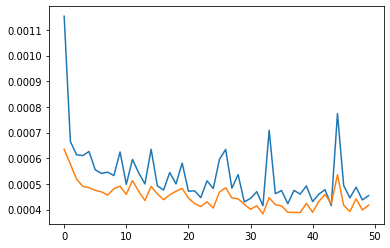

In [ ]:
plt.plot(G_losses_train)
plt.plot(G_losses_valid)

In [ ]:
def test_model():

  Generator.eval()

  for i in range(10):
    real_im = valid_set[i]
    #image = transforms.ToTensor()(image)
    #image = image.type(torch.FloatTensor)
    #image = image.unsqueeze(0)
    #image = image*2.0-1

    #transforms.ToPILImage()((image[0]+1)/2).save("real"+str(i)+".jpg")
    transforms.ToPILImage()(real_im).save("original"+str(i)+".jpg")

    augmented_im = real_im.clone()
    augmented_im = transforms.Resize(size=(64, 64))(augmented_im)
    augmented_im = transforms.Resize(size=(128, 128))(augmented_im)

    augmented_im = augmented_im.unsqueeze(0)
    #print(augmented_im.shape)

    transforms.ToPILImage()(augmented_im[0]).save("input"+str(i)+".jpg")

    output = Generator(augmented_im.cuda())
    #output = (output+1)/2
    output = output.clamp(0.0, 1.0)
    transforms.ToPILImage()(output[0].detach().cpu()).save("result" + str(i) + ".jpg")

  Generator.train()

In [ ]:
test_model()